In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-09-15 12:21:37 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-09-15 12:21:37 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-09-15 12:21:37 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-09-15 12:21:40 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 12:21:40 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-09-15 12:21:40 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-09-15 12:21:40 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-09-15 12:21:41 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-09-15 12:21:41 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-09-15 12:21:41 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-09-15 12:21:41 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-09-15 12:21:41 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-09-15 12:22:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-09-15 12:22:31 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-09-15 12:22:31 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



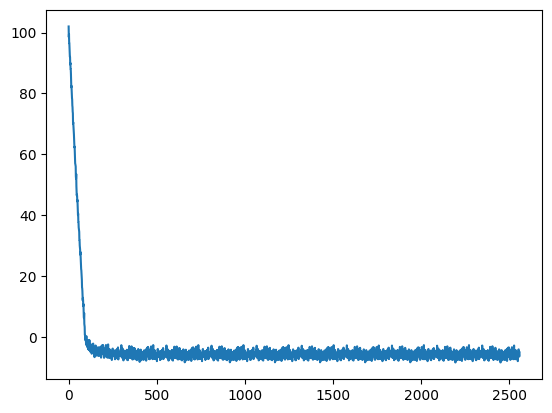

In [7]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     model_key.split("/")[-1],
#     # "distinct_options",
#     f"{select_task.task_name}",
#     "epoch_10.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)



optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


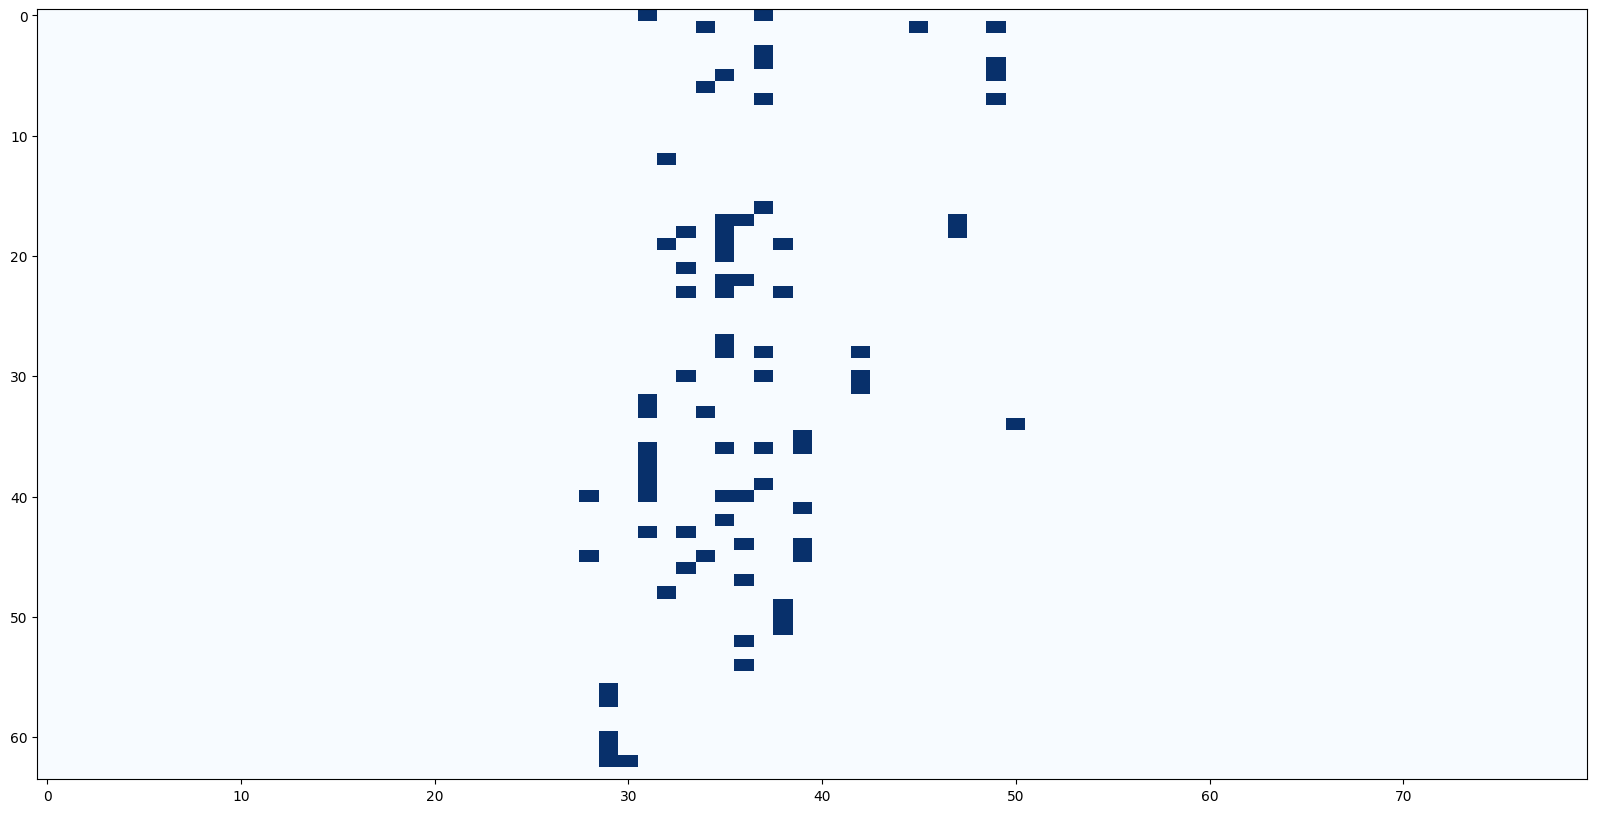

In [8]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

In [11]:
from src.selection.data import MCQify_sample

sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)
sample = MCQify_sample(sample, mt)

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.96 GiB. GPU 0 has a total capacity of 79.25 GiB of which 86.56 MiB is free. Process 1939313 has 16.87 GiB memory in use. Process 2168104 has 17.41 GiB memory in use. Process 2238856 has 17.49 GiB memory in use. Including non-PyTorch memory, this process has 27.35 GiB memory in use. Of the allocated memory 26.95 GiB is allocated by PyTorch, and 1.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [11]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(option_style="single_line"),
    options=sample.options,
    mt=mt,
    heads=heads_selected,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-09-15 11:57:07 src.selection.functional DEBUG    Predictions: ['" Cherry"[45805] (p=0.812, logit=21.875)', '" The"[578] (p=0.085, logit=19.625)', '" Among"[22395] (p=0.046, logit=19.000)', '" A"[362] (p=0.025, logit=18.375)', '" CH"[6969] (p=0.003, logit=16.375)']
2025-09-15 11:57:07 src.selection.functional INFO     Combined attention matrix for all heads


## Apply Logit Lens on the OV contribution

In [49]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.tokens import prepare_input

HEADS = copy.deepcopy(heads_selected)
tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in HEADS:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_head_contributions=head_contributions[layer_idx],
        ),
        attn_block,
    )

logit_location = (mt.lm_head_name, -1)
logit = get_hs(
    mt=mt,
    input=tokenized,
    locations = logit_location,
    return_dict=False
)

mt.reset_forward()
mt.set_attn_implementation("eager")

pred = interpret_logits(
    logits=logit,
    tokenizer=mt.tokenizer,
)

2025-09-15 12:11:06 src.hooking.llama_attention WARNING  model.layers.34.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=23.875, __attn_output.norm().item()=23.875
2025-09-15 12:11:06 src.hooking.llama_attention WARNING  model.layers.37.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=11.6875, __attn_output.norm().item()=11.6875


In [55]:
from src.functional import logit_lens

# head_contrib = head_contributions[35][19][:, -1, :]
head_contrib = []
for layer_idx, head_idx in HEADS:
    head_contrib.append(head_contributions[layer_idx][head_idx][:, -1, :].squeeze().cuda())

head_contrib = torch.stack(head_contrib).sum(dim=0)

logit_lens(
    mt=mt,
    h=head_contrib,
    interested_tokens=[sample.ans_token_id]
)

# head_contrib.shape

([PredictedToken(token=' McInt', prob=0.0150146484375, logit=9.5, token_id=85581, metadata=None),
  PredictedToken(token=' appe', prob=0.010986328125, logit=9.1875, token_id=2708, metadata=None),
  PredictedToken(token='::|', prob=0.00909423828125, logit=9.0, token_id=113141, metadata=None),
  PredictedToken(token='_REST', prob=0.00909423828125, logit=9.0, token_id=56233, metadata=None),
  PredictedToken(token='abra', prob=0.007080078125, logit=8.75, token_id=45032, metadata=None)],
 OrderedDict([(45805,
               (21720,
                PredictedToken(token=' Cherry', prob=7.271766662597656e-06, logit=1.8671875, token_id=45805, metadata=None)))]))

In [61]:
from src.functional import free_gpu_cache
del head_contributions
del head_contrib
free_gpu_cache()

## Just apply Logit Lens on the Latents

In [58]:
hs = get_hs(
    mt=mt,
    input=tokenized,
    locations = [(layer_name, -1) for layer_name in mt.layer_names],
    return_dict=True
)

for layer_idx in range(mt.n_layer):
    layer_name = mt.layer_name_format.format(layer_idx)
    h = hs[(layer_name, -1)]
    ll_pred, ll_track = logit_lens(
        mt=mt,
        h=h,
        interested_tokens=[sample.ans_token_id]
    )
    print(f"{layer_name} | Rank(ans): {ll_track[sample.ans_token_id][0]} | {[str(pred) for pred in ll_pred]}")

model.layers.0 | Rank(ans): 16877 | ['"ogo"[24404] (p=0.002, logit=6.188)', '"abi"[26140] (p=0.001, logit=6.094)', '"럴"[121408] (p=0.001, logit=6.062)', '"ioni"[19350] (p=0.001, logit=6.062)', '"rvine"[67674] (p=0.001, logit=6.000)']
model.layers.1 | Rank(ans): 9265 | ['" rem"[1323] (p=0.002, logit=6.688)', '"럴"[121408] (p=0.002, logit=6.594)', '"abi"[26140] (p=0.002, logit=6.562)', '"陰"[127122] (p=0.002, logit=6.312)', '" unm"[38531] (p=0.002, logit=6.281)']
model.layers.2 | Rank(ans): 54663 | ['" Mig"[38651] (p=0.007, logit=8.125)', '" bois"[66304] (p=0.005, logit=7.812)', '"abi"[26140] (p=0.005, logit=7.781)', '"rax"[69865] (p=0.005, logit=7.688)', '"uni"[16080] (p=0.004, logit=7.625)']
model.layers.3 | Rank(ans): 21750 | ['"uni"[16080] (p=0.010, logit=8.688)', '"eni"[34229] (p=0.005, logit=7.906)', '"ARA"[55062] (p=0.003, logit=7.594)', '"rax"[69865] (p=0.003, logit=7.594)', '" bois"[66304] (p=0.003, logit=7.531)']
model.layers.4 | Rank(ans): 11466 | ['" Oswald"[90450] (p=0.005, lo